In [ ]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import json
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from ts2vec import TS2Vec


In [ ]:
from utils import load_dataset

# Configurations

In [4]:
config = dict(
    batch_size=2,
    lr=0.001,
    output_dims=1024,
    max_train_length=5000
)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"

# Load dataset

In [7]:
def load_files(files, labels, max_len=5000):
    data_arr = []
    final_labels = []
    
    for filepath, label in zip(files, labels):
        df = pd.read_csv(filepath)
        x = df['time'].astype(np.float32).values

        if len(x) == 0:
            print(f"File {filepath} is empty.")
            continue

        start = 0.05 * len(x)
        end = 0.95 * len(x)
        x = x[int(start):int(end)]

        if max_len is not None:
            if len(x) > max_len:
                x = x[:max_len]
            if len(x) < max_len:
                x = np.pad(x, (0, max_len - len(x)), 'constant', constant_values=(0))

        # x = np.expand_dims(x, axis=1)

        # cdf = calculate_cdf(x)
        x = np.expand_dims(x, axis=1)

        data_arr.append(x)
        final_labels.append(label)
    
    return np.array(data_arr), np.array(final_labels)

In [8]:
def get_data(data_files):
    files = []
    labels = []

    for operator in data_files:
        files.extend(data_files[operator]['files'])
        labels.extend([data_files[operator]['label']]*len(data_files[operator]['files']))


    data, labels = load_files(files, labels)

    return data, labels

In [9]:
nexmark_dataset = load_dataset.load_nexmark_data(is_split=False)
nexmark_data, nexmark_labels = get_data(nexmark_dataset)

File ./nexmark_dataset/q2_filter/tail_0_292_filter_bidder_is_not_divisible_by_sum_of_field_moduli.csv is empty.
File ./nexmark_dataset/q6_filter/tail_0_292_filter_bidder_is_not_divisible_by_sum_of_field_moduli+292_filter_category_times_id_plus_seller_mod_duration_is_less_than_initialBid.csv is empty.


# Load TS2VEC model

In [ ]:
model = TS2Vec(
    input_dims=1,
    device=device,
    **config
)

model.load(f'models/ts2vec_model_5000_1024.pkl')

In [10]:
embeddings = model.encode(nexmark_data, encoding_window='full_series')


In [15]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)  # You can tune perplexity
reduced = tsne.fit_transform(embeddings)

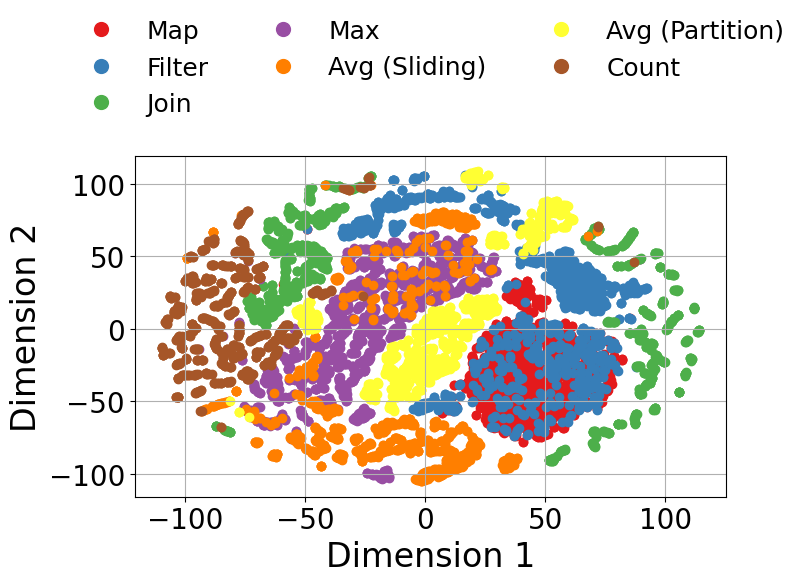

In [ ]:
# Unique labels and color mapping
# nexmark_labels_str = [load_dataset.NEXMARK_CLASS_NAMES[label] for label in nexmark_labels]
class_names =['Map', 'Filter', 'Join', 'Max', 'Avg (Sliding)', 'Avg (Partition)', 'Count']
unique_labels = sorted(set(nexmark_labels))
palette = sns.color_palette("Set1", len(unique_labels))
label_to_color = {label: palette[i] for i, label in enumerate(unique_labels)}

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(nexmark_labels):
    plt.scatter(reduced[i, 0], reduced[i, 1], color=label_to_color[label], label=label if label not in nexmark_labels[:i] else "")
    # plt.text(reduced[i, 0], reduced[i, 1], file_names[i], fontsize=8)

# One legend entry per class
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label], markersize=12, label=class_names[label]) for label in unique_labels]
plt.legend(handles=handles, fontsize=20, loc='center left', title_fontsize='18', bbox_to_anchor=(1, 0.5))
plt.legend(
    handles=handles,
    # title='Class',
    fontsize=18,
    loc='lower center',
    bbox_to_anchor=(0.5, 1.05),  # x=0.5 centers it, y=1.05 puts it slightly above the plot
    ncol=3,           # put all entries in one row
    frameon=False                # optional: removes the box around the legend
)

# plt.title('t-SNE of TS2Vec Embeddings')
plt.xlabel('Dimension 1', fontsize=24)
plt.ylabel('Dimension 2', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig('results/nexmark_tsne_plot.pdf')
plt.show()